In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,make_scorer
import xgboost as xgb

## Loading training data and analysing training data

In [2]:
#Load Train Data
df_train = pd.read_csv('train_Df64byy.csv')

In [3]:
# Checking for null values
df_train.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

As can be Seen, 3 columns- Health Indicator, Holding_Policy_Duration, Holding_Policy_Type have missing values. It was mentioned in the problem statement and those who do not hold any insurance policy also gets the recommendation. So, One assumption that I am Taking is that wherever there are NaN values in Holding_Policy_Type and Holding_Policy_Duration, They do not have purchased insurance of the company before.
So , Imputed Holding_Policy_Duration- imputed with '0.0' and Holding_Policy_Type- Imputed with 0. Health Indicator was imputed using the mode value

In [99]:
df_train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
df_train[df_train[['Holding_Policy_Duration','Holding_Policy_Type']].isnull().any(axis=1)]

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
10,11,C28,600,Owned,Individual,21,21,No,X2,NaN,NaN,21,4068.0,1
13,14,C5,900,Rented,Individual,20,20,No,X2,NaN,NaN,18,8364.0,0
15,16,C3,1484,Rented,Individual,20,20,No,X3,NaN,NaN,2,4912.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50863,50864,C1,3705,Owned,Individual,75,75,No,X3,NaN,NaN,16,17850.0,1
50864,50865,C27,3469,Owned,Individual,72,72,No,X4,NaN,NaN,2,17312.0,0
50865,50866,C21,4915,Owned,Individual,74,74,No,NaN,NaN,NaN,14,19944.0,0
50867,50868,C6,2040,Owned,Individual,37,37,No,X2,NaN,NaN,20,10016.0,0


In [5]:
df_train.shape

(50882, 14)

In [6]:
df_train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

In [7]:
df_train['Response'].value_counts()

0    38673
1    12209
Name: Response, dtype: int64

The dataset is imbalanced and there are missing values in 3 columns namely Health_Indicator,Holding_Policy_Duration and Holding_Policy_Type. 

In [8]:
df_train['Holding_Policy_Duration'].value_counts()

1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

In [9]:
df_train['Holding_Policy_Type'].value_counts()

3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

In [10]:
df_train['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

## Data Cleaning and Data Prep

In [74]:
def label_encoding(data,other_cols=[]):
    '''
    Function which does the label encoding in the input data and returns a label encoded dataframe. 
    
    input- 
    data - The clean dataframe without any missing values
    other_cols(dafault=[])- Any other column that we want to label encode
    
    returns- 
    df- with label encoded columns
    le_dict- containing LabelEncoder() object which can be used on the test set.
    
    '''
    df = data.copy()
    cols_list = df.select_dtypes('object').columns
    le_dict = {}
    for cols in cols_list:
        print(cols)
        le = LabelEncoder()
        df[cols] = le.fit_transform(df[cols])
        print(cols)
        le_dict[cols] = le
    
    if len(other_cols)!=0:
        for cols in other_cols:
            le = LabelEncoder()
            df[cols] = le.fit_transform(df[cols])
            print(cols)
            le_dict[cols] = le
    return df,le_dict

In [75]:
def clean_data(data):
    '''
    Function for imputing missing values. It returns the clean dataframe with a dictionary which contains what values to be 
    used for missing value imputation(for each feature) in the test set.
    
    input: 
    data(dataframe)
    
    output: 
    df- dataframe with missing values imputed
    miss_dict- dictionary containing the values which can be used for missing value imputation in the test set.
    '''
    df = data.copy()
    nullval = df.isnull().sum()
    cols_list = nullval[nullval!=0].index
    other_cols_list = nullval[nullval==0].index
    miss_dict = {}
    for col in cols_list:
        if col in df.select_dtypes('object'):
            if col in ['Holding_Policy_Type','Holding_Policy_Duration']:
                df[col] = df[col].fillna('0.0')
                miss_dict[col] = '0.0'
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
                miss_dict[col] = df[col].mode()[0]
        else:
            if col in ['Holding_Policy_Type','Holding_Policy_Duration']:
                df[col] = df[col].fillna(0.0)
                miss_dict[col] = 0.0
            else:
                df[col] = df[col].fillna(df[col].median())
                miss_dict[col] = df[col].median()
    for col in other_cols_list:
        if col in df.select_dtypes('object'):
            miss_dict[col] = df[col].mode()[0]
        else:
            miss_dict[col] = df[col].median()
    return df,miss_dict

In [12]:
df_train.select_dtypes('object').columns

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration'],
      dtype='object')

In [13]:
df_train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

### Adding New Feature Named delta in the data. Delta= (Upper_Age-Lower_Age). This was done due to the high correlation between Upper_Age and Lower_Age 

In [15]:
df_clean,miss_dict = clean_data(df_train)
df_clean['delta'] = df_clean['Upper_Age']-df_clean['Lower_Age']# Adding new feature in our data

In [16]:
miss_dict

{'Health Indicator': 'X1',
 'Holding_Policy_Duration': '0.0',
 'Holding_Policy_Type': 0.0,
 'ID': 25441.5,
 'City_Code': 'C1',
 'Region_Code': 1391.0,
 'Accomodation_Type': 'Owned',
 'Reco_Insurance_Type': 'Individual',
 'Upper_Age': 44.0,
 'Lower_Age': 40.0,
 'Is_Spouse': 'No',
 'Reco_Policy_Cat': 17.0,
 'Reco_Policy_Premium': 13178.0,
 'Response': 0.0}

In [17]:
df_clean['Holding_Policy_Type'] = df_clean['Holding_Policy_Type'].astype(int)

In [18]:
df_clean.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,delta
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3,22,11628.0,0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,0.0,0,22,30510.0,0,53
2,3,C5,3732,Owned,Individual,32,32,No,X1,1.0,1,19,7450.0,1,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3,19,17780.0,0,4
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1,16,10404.0,0,0


In [19]:
df_clean.isnull().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
delta                      0
dtype: int64

In [20]:
df_enc,le_dict = label_encoding(df_clean)

City_Code
City_Code
Accomodation_Type
Accomodation_Type
Reco_Insurance_Type
Reco_Insurance_Type
Is_Spouse
Is_Spouse
Health Indicator
Health Indicator
Holding_Policy_Duration
Holding_Policy_Duration


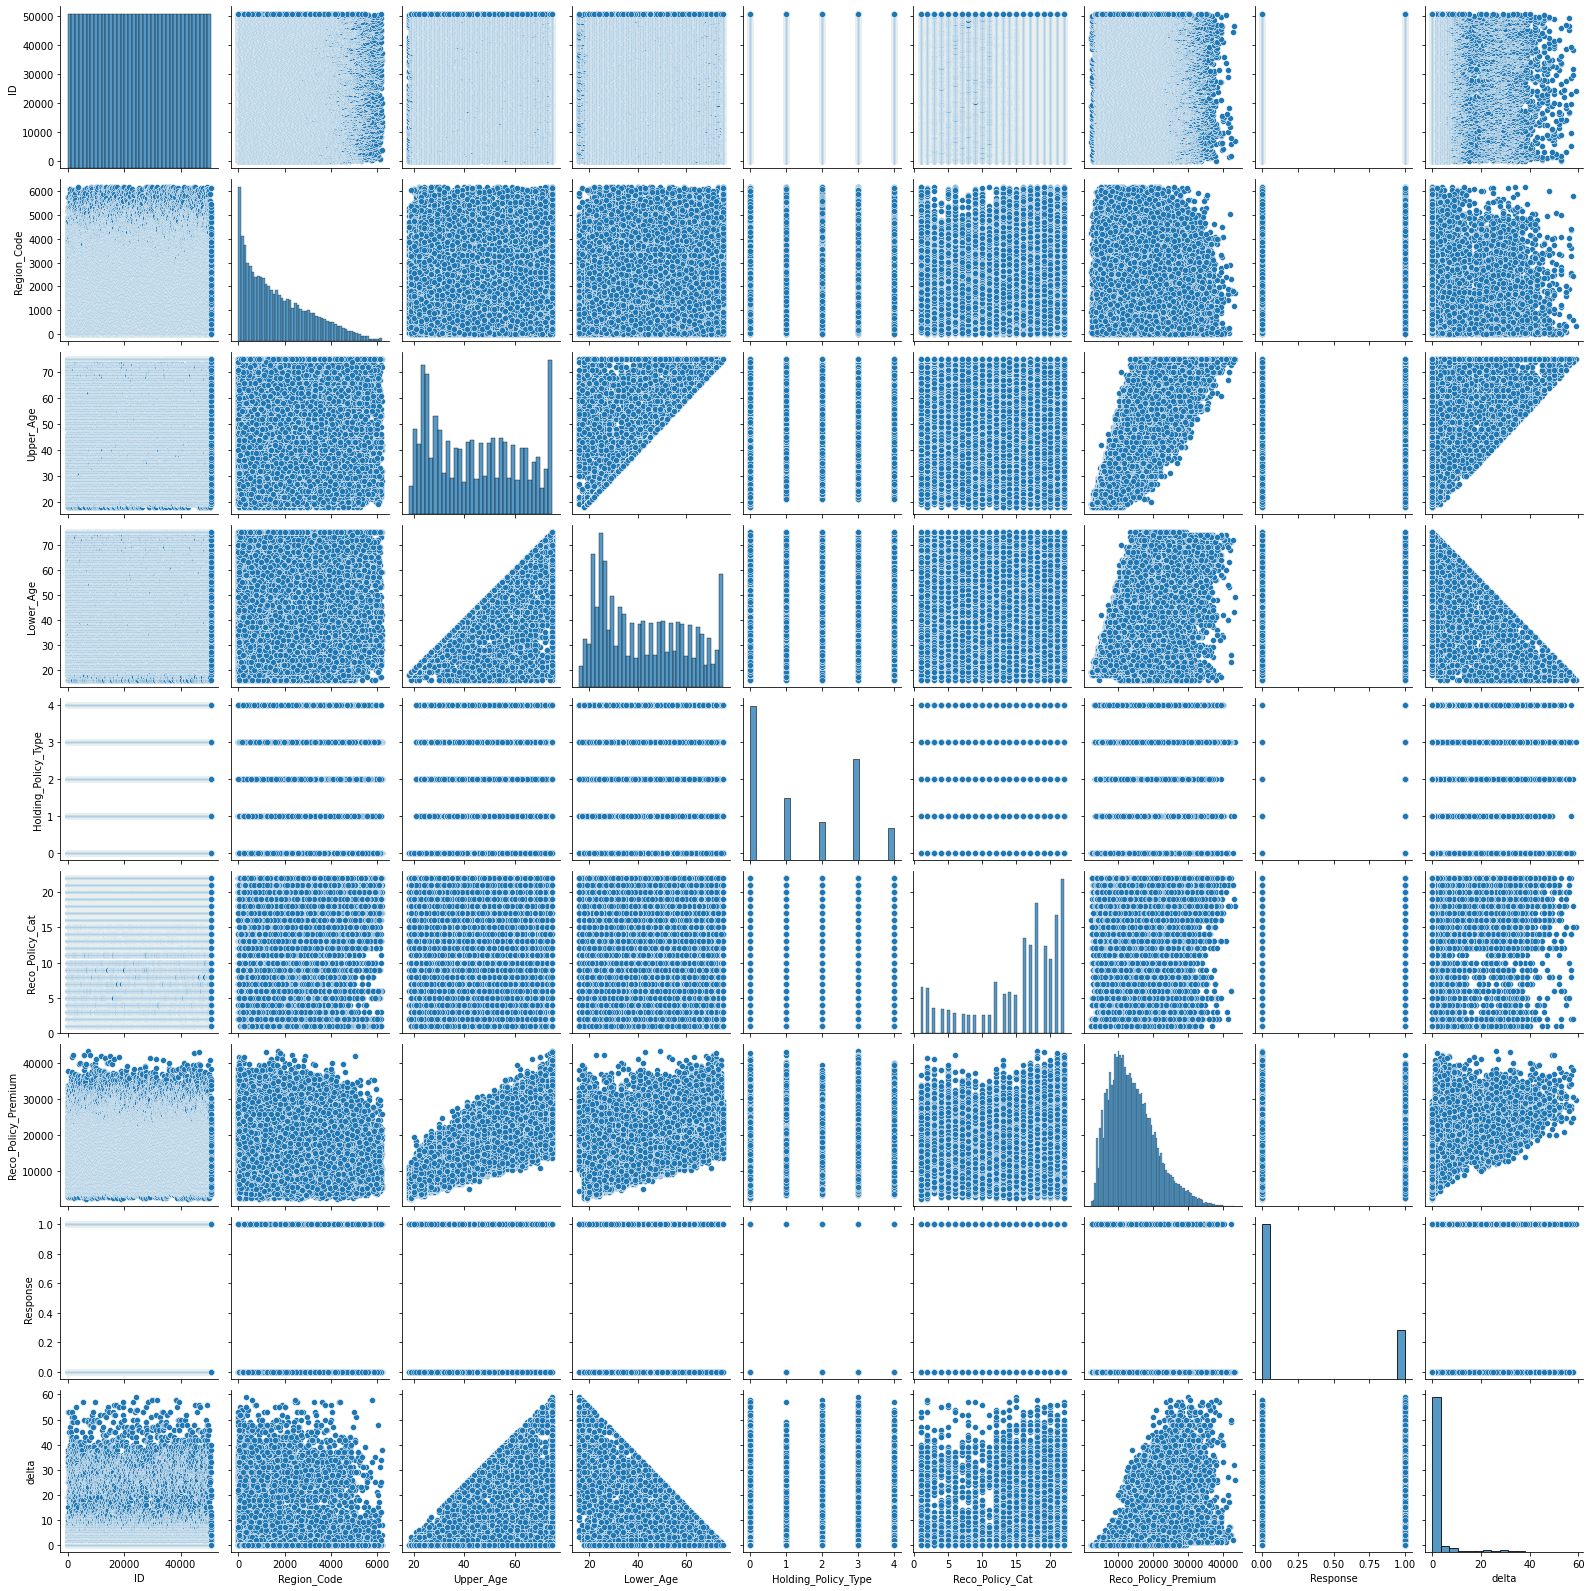

In [21]:
sns.pairplot(df_clean)

<AxesSubplot:>

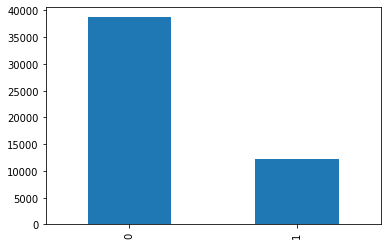

In [22]:
df_clean['Response'].value_counts().plot.bar()

### There is a class imbalance in our data which can be made balanced using Oversampling or SMOTE. Also, Looking at the distributions, We know that the lower age and upper age have similar distributions, Also, the correlation shows higher correlation for the upper age and lower age. SO, a new feature named delta(Upper_Age-Lower_Age) is introduced here and Upper_Age is dropped. 

<AxesSubplot:>

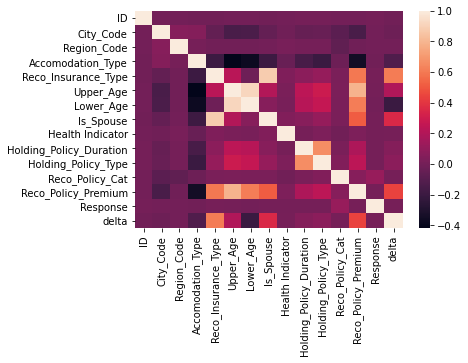

In [23]:
sns.heatmap(df_enc.corr())

In [24]:
df_enc.corr()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,delta
ID,1.000000,-0.003275,-0.000465,-0.004649,-0.008505,-0.001725,0.001101,-0.004262,0.001563,0.002275,0.003538,-0.002235,-0.002350,0.005159,-0.007126
City_Code,-0.003275,1.000000,0.059562,0.054010,-0.053742,-0.144504,-0.136441,-0.052259,-0.012762,-0.046386,-0.040456,-0.084928,-0.144310,-0.000495,-0.020150
Region_Code,-0.000465,0.059562,1.000000,0.009105,-0.004275,-0.005649,-0.005928,-0.002567,0.017058,0.005940,0.003002,-0.065120,-0.010797,0.001121,0.000711
Accomodation_Type,-0.004649,0.054010,0.009105,1.000000,-0.196833,-0.419129,-0.369400,-0.191045,-0.038414,-0.148825,-0.199022,-0.022055,-0.350514,-0.005201,-0.124898
Reco_Insurance_Type,-0.008505,-0.053742,-0.004275,-0.196833,1.000000,0.227119,-0.014998,0.881560,0.039813,0.074350,0.112866,0.020826,0.596160,0.009891,0.610488
Upper_Age,-0.001725,-0.144504,-0.005649,-0.419129,0.227119,1.000000,0.921392,0.202947,0.019547,0.240041,0.295469,0.025257,0.792689,0.002772,0.196978
Lower_Age,0.001101,-0.136441,-0.005928,-0.369400,-0.014998,0.921392,1.000000,0.062634,0.014362,0.218664,0.264718,0.021163,0.615739,-0.002099,-0.199526
Is_Spouse,-0.004262,-0.052259,-0.002567,-0.191045,0.881560,0.202947,0.062634,1.000000,0.042963,0.067883,0.108602,0.022676,0.514727,0.003859,0.353700
Health Indicator,0.001563,-0.012762,0.017058,-0.038414,0.039813,0.019547,0.014362,0.042963,1.000000,0.008727,0.030172,-0.004402,0.033874,0.002239,0.013053
Holding_Policy_Duration,0.002275,-0.046386,0.005940,-0.148825,0.074350,0.240041,0.218664,0.067883,0.008727,1.000000,0.666391,0.022155,0.185541,0.005206,0.053610


In [25]:
df_enc.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,delta
0,1,22,3213,1,0,36,36,0,0,6,3,22,11628.0,0,0
1,2,31,1117,0,1,75,22,0,1,0,0,22,30510.0,0,53
2,3,31,3732,0,0,32,32,0,0,1,1,19,7450.0,1,0
3,4,16,4378,0,1,52,48,0,0,6,3,19,17780.0,0,4
4,5,34,2190,1,0,44,44,0,1,9,1,16,10404.0,0,0


<AxesSubplot:>

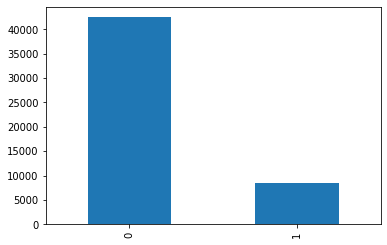

In [93]:
df_enc['Is_Spouse'].value_counts().plot.bar()

<AxesSubplot:>

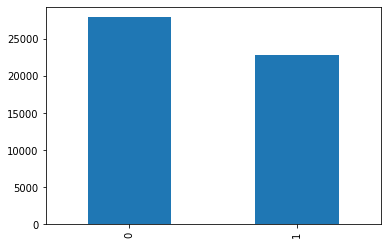

In [94]:
df_enc['Accomodation_Type'].value_counts().plot.bar()

<AxesSubplot:>

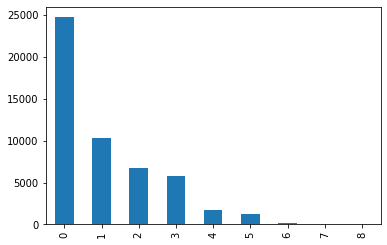

In [96]:
df_enc['Health Indicator'].value_counts().plot.bar()

## Building models

In [76]:
def accuracy_metric(ytrue,ypred):
    '''
    Function which takes in an array of predicted value and array of actuals and returns the accuracy(measured as %age of places
    where labels match).
    
    input-
    ytrue: True Labels or actual labels
    ypred: Predicted Labels
    
    returns-
    score- The Accuracy Score
    
    '''
    score = sum(ypred==ytrue)/len(ypred)
    return score

In [78]:
def rf_grid_search(model,params_grid,xtrain,ytrain):
    '''
    Function which does grid search on random forest model and returns the best parameters dictionary
    and also the estimator(model)
    
    input-
    model- Model object(Random forest in this case)
    params_grid- Dictionary containing parameter name with list of values it can take
    xtrain- input train data
    ytrain- target train data
    
    returns-
    clf_search- best estimator(model object)
    clf_search.best_params_- parameters of the best estimator.
    
    '''
    score_obj = make_scorer(accuracy_metric, greater_is_better=True)
    clf_search = GridSearchCV(model, params_grid,scoring=score_obj,verbose=2)
    clf_search.fit(xtrain,ytrain)
    return clf_search,clf_search.best_params_

In [79]:
def xgboost_grid_search(model,params_grid,xtrain,ytrain):
    '''
    Function which does grid search on xgboost model and returns the best parameters dictionary and 
    also the estimator(model)
    
    input-
    model- Model object(xgboost in this case)
    params_grid- Dictionary containing parameter name with list of values it can take
    xtrain- input train data
    ytrain- target train data
    
    returns-
    clf_search- best estimator(model object)
    clf_search.best_params_- parameters of the best estimator.
    
    '''
    score_obj = make_scorer(accuracy_metric, greater_is_better=True)
    clf_search = GridSearchCV(model, params_grid,scoring=score_obj,verbose=2)
    clf_search.fit(xtrain,ytrain)
    return clf_search,clf_search.best_params_

In [80]:
def xgboost_random_search(model,params_grid,xtrain,ytrain):
    '''
    Function which does random search on xgboost model and returns the best parameters dictionary and also the estimator(model)
    
    input-
    model- Model object(xgboost in this case)
    params_grid- Dictionary containing parameter name with list of values it can take
    xtrain- input train data
    ytrain- target train data
    
    returns-
    clf_search- best estimator(model object)
    clf_search.best_params_- parameters of the best estimator.
    
    '''
    score_obj = make_scorer(accuracy_metric, greater_is_better=True)
    clf_search = RandomizedSearchCV(model, params_grid,scoring=score_obj,n_iter=10,verbose=2)
    clf_search.fit(xtrain,ytrain)
    return clf_search,clf_search.best_params_

In [81]:
def rf_random_search(model,params_grid,xtrain,ytrain):
    '''
    Function which does random search on random forest model and returns the best parameters dictionary 
    and also the estimator(model)
    
    input-
    model- Model object(Random forest in this case)
    params_grid- Dictionary containing parameter name with list of values it can take
    xtrain- input train data
    ytrain- target train data
    
    returns-
    clf_search- best estimator(model object)
    clf_search.best_params_- parameters of the best estimator.
    
    '''
    score_obj = make_scorer(accuracy_metric, greater_is_better=True)
    clf_search = RandomizedSearchCV(model, params_grid,scoring=score_obj,n_iter=50,verbose=2)
    clf_search.fit(xtrain,ytrain)
    return clf_search,clf_search.best_params_

In [83]:
def generate_submission_result(model,testdf,miss_dict,train_cols,le_dict):
    '''
    Function which outputs the submission file(results on the test set). It gives the probability that the person is interested.
    Uses predict_proba to obtain probability.
    
    Inputs-
    model- Model object(Random forest or XGBoost)
    testdf- The test dataframe on which we want to generate result.
    miss_dict- dict containing the values that should be imputed for a feature. Values are calculated on the train set.
    train_cols- columns used while training
    le_dict: dictionary containing LabelEncoder object
    
    Returns-
    testsub- Dataframe containing 'ID'(Unique Identifier) and 'Response'(probability that person is interested)
    
    '''
    nullval_test = testdf.isnull().sum()
    cols_list = nullval_test[nullval_test!=0].index
    for col in cols_list:
        mval = miss_dict[col]
        testdf[col] = testdf[col].fillna(mval)
    testdf['delta'] = testdf['Upper_Age']-testdf['Lower_Age']
    dfx = testdf[train_cols]
    for cols in le_dict.keys():
        dfx[cols] = le_dict[cols].transform(dfx[cols])
    xt = dfx.values
    ypred = model.predict_proba(xt)
    testdf['Response']=ypred[:,1]
    testsub = testdf[['ID','Response']]
    return testsub

In [31]:
# Xov_df = df_enc.drop(['ID','Response','Region_Code','Upper_Age'],axis=1)
Xov_df = df_enc.drop(['ID','Response','Upper_Age'],axis=1)
yov_df = df_enc['Response']

Xov_df = Xov_df.reset_index(drop=True)
yov_df = yov_df.reset_index(drop=True)

train_cols = Xov_df.columns

Xov = Xov_df.values
yov = yov_df.values

### Oversampling for treating imbalanced class (Separating data into train and validation set)

In [32]:
####OVERSAMPLING AND SMOTE Tried in this block
ros = RandomOverSampler(sampling_strategy='minority')
smote = SMOTE()
X,y = ros.fit_resample(Xov,yov)
# X,y = smote.fit_resample(Xov,yov)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y, random_state=0)

### Loading Test data Provided

In [33]:
testdf = pd.read_csv('test_YCcRUnU.csv')

In [34]:
testdf.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


### Random Forest model with Default Parameters

In [35]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
ypred_rf = model.predict(X_test)

In [36]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Accuracy on the validation set
accuracy_metric(y_test,ypred_rf)

0.9225597931480285

In [38]:
test_sub = generate_submission_result(model,testdf,miss_dict,train_cols,le_dict)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [39]:
# test_sub.to_csv('submissions/submission4.csv',index=False)

### XGBoost with default params

In [40]:
modelxgb = xgb.XGBClassifier(max_depth=35,learning_rate=0.3)
modelxgb.fit(X_train,y_train)
ypred_xgb = modelxgb.predict(X_test)

C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
modelxgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 35,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [42]:
accuracy_metric(y_test,ypred_xgb)

0.9002585649644473

In [43]:
ts = generate_submission_result(model,testdf,miss_dict,train_cols,le_dict)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [44]:
# test_sub.to_csv('submissions/submission4.csv',index=False)

### XGBoost Hyperparameter Optimization Random Search 

In [55]:
params_grid = {
    'learning_rate':[0.0003,0.003,0.03,0.1,0.3],
    'gamma':[0,1,2,3,5],
    'max_depth':[25,30,35,40,45],
    'n_estimators':[100]
}

In [56]:
estimator = xgb.XGBClassifier()
clfxgb,best_params = xgboost_random_search(estimator,params_grid,X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.1, max_depth=30, n_estimators=100; total time=  20.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.1, max_depth=30, n_estimators=100; total time=  23.3s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.1, max_depth=30, n_estimators=100; total time=  23.0s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.1, max_depth=30, n_estimators=100; total time=  20.4s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.1, max_depth=30, n_estimators=100; total time=  23.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  21.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  17.4s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  18.8s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  19.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=5, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  22.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  24.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  22.0s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  24.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  26.0s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  22.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.0003, max_depth=25, n_estimators=100; total time=  27.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.0003, max_depth=25, n_estimators=100; total time=  27.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.0003, max_depth=25, n_estimators=100; total time=  27.1s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.0003, max_depth=25, n_estimators=100; total time=  28.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.0003, max_depth=25, n_estimators=100; total time=  29.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.003, max_depth=40, n_estimators=100; total time=  38.3s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.003, max_depth=40, n_estimators=100; total time=  35.4s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.003, max_depth=40, n_estimators=100; total time=  34.6s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.003, max_depth=40, n_estimators=100; total time=  33.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.003, max_depth=40, n_estimators=100; total time=  36.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  22.8s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  24.4s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  23.0s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  21.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=1, learning_rate=0.3, max_depth=35, n_estimators=100; total time=  25.2s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  26.6s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  21.6s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  23.8s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  24.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.3, max_depth=40, n_estimators=100; total time=  23.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=3, learning_rate=0.03, max_depth=30, n_estimators=100; total time=  31.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=3, learning_rate=0.03, max_depth=30, n_estimators=100; total time=  30.8s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=3, learning_rate=0.03, max_depth=30, n_estimators=100; total time=  38.8s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=3, learning_rate=0.03, max_depth=30, n_estimators=100; total time=  34.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=3, learning_rate=0.03, max_depth=30, n_estimators=100; total time=  31.4s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.0003, max_depth=40, n_estimators=100; total time=  34.2s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.0003, max_depth=40, n_estimators=100; total time=  35.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.0003, max_depth=40, n_estimators=100; total time=  35.6s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.0003, max_depth=40, n_estimators=100; total time=  34.2s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=2, learning_rate=0.0003, max_depth=40, n_estimators=100; total time=  33.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.003, max_depth=30, n_estimators=100; total time=  30.5s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.003, max_depth=30, n_estimators=100; total time=  30.3s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.003, max_depth=30, n_estimators=100; total time=  29.9s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.003, max_depth=30, n_estimators=100; total time=  29.7s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0, learning_rate=0.003, max_depth=30, n_estimators=100; total time=  30.0s


C:\Users\HP\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [57]:
ypredxgb = clfxgb.predict(X_test)
accuracy_metric(y_test,ypredxgb)

0.8867485455720749

In [58]:
testxgb = generate_submission_result(clfxgb,testdf,miss_dict,train_cols,le_dict)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [62]:
#testxgb.to_csv('submissions/submission5.csv',index=False)

### Random Forest Grid Search And Random Search

In [63]:
params_grid_rf = {
    'max_depth':[4,5,6,7,8,9],
    'n_estimators':[10,30,50,70,90,100]
}

In [64]:
# Performing grid search for randomforest
estimator = RandomForestClassifier()
clf_search,best_params_rf = rf_grid_search(estimator,params_grid_rf,X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.9s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.9s
[CV] END .......................max_depth=4, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=4, n_estimators=30; total time=   1.0s
[CV] END .......................max_depth=4, n_estimators=30; total time=   0.8s
[CV] END .......................max_depth=4, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=4, n_

[CV] END .......................max_depth=7, n_estimators=50; total time=   2.3s
[CV] END .......................max_depth=7, n_estimators=50; total time=   2.2s
[CV] END .......................max_depth=7, n_estimators=50; total time=   2.3s
[CV] END .......................max_depth=7, n_estimators=50; total time=   2.3s
[CV] END .......................max_depth=7, n_estimators=70; total time=   3.3s
[CV] END .......................max_depth=7, n_estimators=70; total time=   3.2s
[CV] END .......................max_depth=7, n_estimators=70; total time=   3.4s
[CV] END .......................max_depth=7, n_estimators=70; total time=   4.2s
[CV] END .......................max_depth=7, n_estimators=70; total time=   3.3s
[CV] END .......................max_depth=7, n_estimators=90; total time=   4.1s
[CV] END .......................max_depth=7, n_estimators=90; total time=   4.3s
[CV] END .......................max_depth=7, n_estimators=90; total time=   4.2s
[CV] END ...................

In [65]:
ypredrf = clf_search.predict(X_test)
accuracy_metric(y_test,ypredrf)

0.6244343891402715

In [66]:
test_subrf_grid = generate_submission_result(clf_search,testdf,miss_dict,train_cols,le_dict)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [82]:
#test_subrf_grid.to_csv('submissions/submission6.csv',index=False)

In [69]:
params_grid_rf = {
    'max_depth':[4,5,6,7,8,9,10,11,12,13,14,15],
    'n_estimators':[10,30,50,70,90,100,110,120,150,200]
}
estimator = RandomForestClassifier()
clf_search_random,best_params_rf = rf_random_search(estimator,params_grid_rf,X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ......................max_depth=9, n_estimators=120; total time=   6.6s
[CV] END ......................max_depth=9, n_estimators=120; total time=   6.8s
[CV] END ......................max_depth=9, n_estimators=120; total time=   7.3s
[CV] END ......................max_depth=9, n_estimators=120; total time=   7.1s
[CV] END ......................max_depth=9, n_estimators=120; total time=   6.6s
[CV] END ......................max_depth=14, n_estimators=10; total time=   0.8s
[CV] END ......................max_depth=14, n_estimators=10; total time=   1.0s
[CV] END ......................max_depth=14, n_estimators=10; total time=   0.8s
[CV] END ......................max_depth=14, n_estimators=10; total time=   0.9s
[CV] END ......................max_depth=14, n_estimators=10; total time=   0.9s
[CV] END ......................max_depth=11, n_estimators=10; total time=   0.7s
[CV] END ......................max_depth=11, n_

[CV] END .....................max_depth=10, n_estimators=110; total time=   7.2s
[CV] END .....................max_depth=10, n_estimators=110; total time=   6.1s
[CV] END .....................max_depth=10, n_estimators=110; total time=   6.5s
[CV] END .....................max_depth=10, n_estimators=110; total time=   6.3s
[CV] END ......................max_depth=15, n_estimators=70; total time=   5.6s
[CV] END ......................max_depth=15, n_estimators=70; total time=   5.2s
[CV] END ......................max_depth=15, n_estimators=70; total time=   6.2s
[CV] END ......................max_depth=15, n_estimators=70; total time=   7.3s
[CV] END ......................max_depth=15, n_estimators=70; total time=   5.5s
[CV] END ......................max_depth=9, n_estimators=110; total time=   5.6s
[CV] END ......................max_depth=9, n_estimators=110; total time=   5.9s
[CV] END ......................max_depth=9, n_estimators=110; total time=   5.4s
[CV] END ...................

[CV] END .....................max_depth=14, n_estimators=200; total time=  15.0s
[CV] END .....................max_depth=14, n_estimators=200; total time=  16.7s
[CV] END .....................max_depth=13, n_estimators=150; total time=  10.3s
[CV] END .....................max_depth=13, n_estimators=150; total time=  11.0s
[CV] END .....................max_depth=13, n_estimators=150; total time=  10.7s
[CV] END .....................max_depth=13, n_estimators=150; total time=  11.5s
[CV] END .....................max_depth=13, n_estimators=150; total time=  12.1s
[CV] END ......................max_depth=11, n_estimators=70; total time=   5.0s
[CV] END ......................max_depth=11, n_estimators=70; total time=   4.6s
[CV] END ......................max_depth=11, n_estimators=70; total time=   3.9s
[CV] END ......................max_depth=11, n_estimators=70; total time=   4.9s
[CV] END ......................max_depth=11, n_estimators=70; total time=   4.6s
[CV] END ...................

In [70]:
ypredrf = clf_search_random.predict(X_test)
accuracy_metric(y_test,ypredrf)

0.7672915319974144

In [71]:
test_subrf_random = generate_submission_result(clf_search_random,testdf,miss_dict,train_cols,le_dict)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [73]:
#test_subrf_random.to_csv('submissions/submission6.csv',index=False)